<img src='titanic_01.png' align="center"  width="1000">

# 0. Intro

The famous Titanic dataset is used by people all over the world, in many cases as the first ML challenge taken on by Data Science students - as was my case. The goal of the [“Titanic: Machine Learning from Disaster” Competition](https://www.kaggle.com/c/titanic/overview) is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. 

This was my first attempt at solving a Kaggle competition, just a couple of months after beginning my Data Science studies. This analysis was submitted as an assignment in the [Data Science course at Digital House Coding School](https://www.digitalhouse.com/br/curso/data-science) in São Paulo, Brazil.

### 0.1. The Challenge

_"The sinking of the Titanic is one of the most infamous shipwrecks in history._

_On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew._

_While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others."_

The point of the Titanic challenge is to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc). 

# 1. Importing Libraries & Data

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

# Data prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Statistics
import scipy
from scipy import stats
from sklearn.feature_selection import f_classif, chi2
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, roc_auc_score

# Confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Models
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

Kaggle makes two similar datasets available, titled `train.csv` and `test.csv`, both of which are available at https://www.kaggle.com/c/titanic/data.

* `train.csv` contains the details of a subset of the passengers on board (891 to be exact) and reveals whether they survived or not, also known as the “ground truth”.

* `test.csv` contains similar information but does not disclose the “ground truth” for each passenger, and I will attempt to predict these outcomes.

In [2]:
# Load data & assign dorky names
df_traintanic = pd.read_csv('train.csv')
df_testanic = pd.read_csv('test.csv')

I find it useful to look at the first few lines of a dataset in order to confirm if they loaded correctly, and also to start getting familiar with the data:

In [3]:
# Train DF
df_traintanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
# Test DF
df_testanic.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [5]:
# High level summary
print(f'Train set: {df_traintanic.shape} & Test set: {df_testanic.shape}')

Train set: (891, 12) & Test set: (418, 11)


### 1.1. Split Dataset into Train & Test

In [6]:
# Train/test split
df_train, df_test = train_test_split(df_traintanic,
                                     train_size=0.8,
                                     #stratify=df_traintanic['Survived'],
                                     random_state=42)

In [7]:
print('The number of samples in the train set is {}.'.format(df_train.shape[0]))

The number of samples in the train set is 712.


In [8]:
print('The number of samples in the test set is {}.'.format(df_test.shape[0]))

The number of samples in the test set is 179.


In [9]:
if df_train.shape[1] == df_test.shape[1]:
    print(f'Both train & test sets have {df_train.shape[1]} columns')
else:
    print(f'Confirm: train set has {df_train.shape[1]} columns and test set has {df_test.shape[1]} columns')

Both train & test sets have 12 columns


# 2. Data Exploration & Cleansing

In [10]:
# Create copy of train set to work on
train_data01 = df_train.copy()

In [11]:
# Data types
train_data01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 331 to 102
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          572 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        159 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


Kaggle offers more information on these features, which is helpful to understand how to manipulate them and spot any possible inconsistencies/errors:

| Variable | Definition | Key | Notes |
| :-- | :-- | :-- | :-- |
| survival | Survival | 0 = No, 1 = Yes |    |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |    |    |
| Age | Age in years |    | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 |
|sibsp | # of siblings / spouses aboard the Titanic |    | Sibling = brother, sister, stepbrother, stepsister Spouse = husband, wife  |
|parch | # of parents / children aboard the Titanic |    | Parent = mother, father; Child = daughter, son, stepdaughter, stepson; some children travelled only with a nanny, therefore parch=0 for them |
|ticket | Ticket number |    |	|
|fare | Passenger fare |    |  |
| cabin | Cabin number |    |  |
embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |  |

In [12]:
# Possible inconsistencies (numeric features only)
train_data01.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,572.000000,712.000000,712.000000,712.000000
mean,448.234551,0.376404,2.330056,29.498846,0.553371,0.379213,32.586276
std,256.731423,0.484824,0.824584,14.500059,1.176404,0.791669,51.969529
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,224.750000,0.000000,2.000000,21.000000,0.000000,0.000000,7.925000
50%,453.500000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,673.500000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [13]:
# Missing values
train_data01.isnull().sum()
# train_data01.isnull().sum() / train_data01.shape[0] * 100

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            140
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          553
Embarked         2
dtype: int64

In [14]:
# Percentage of missing values - Age
# print('Percent of missing "Age" records is %.2f%%' %((df_train['Age'].isnull().sum()/df_train.shape[0])*100))
missing_age = round((train_data01['Age'].isnull().sum()/train_data01.shape[0])*100,2)
print(f'Percent of missing "Age" records is {missing_age}%')

Percent of missing "Age" records is 19.66%


In [15]:
# Percentage of missing values - Cabin
# print('Percent of missing "Cabin" records is %.2f%%' %((train_data01['Cabin'].isnull().sum()/train_data01.shape[0])*100))
missing_cabin = round((train_data01['Cabin'].isnull().sum()/train_data01.shape[0])*100,2)
print(f'Percent of missing "Cabin" records is {missing_cabin}%')

Percent of missing "Cabin" records is 77.67%


In [16]:
# Percentage of missing values - Embarked
# print('Percent of missing "Embarked" records is %.2f%%' %((train_data01['Embarked'].isnull().sum()/train_data01.shape[0])*100))
missing_embarked = round((train_data01['Embarked'].isnull().sum()/train_data01.shape[0])*100,2)
print(f'Percent of missing "Embarked" records is {missing_embarked}%')

Percent of missing "Embarked" records is 0.28%


In [17]:
# Duplicate lines
n_dupe_samples = train_data01.shape[0] - train_data01.drop_duplicates().shape[0]
print(f'There are {n_dupe_samples} duplicate lines')

There are 0 duplicate lines


In [18]:
# Duplicate columns
dupe_columns = []
for col1 in train_data01.columns.tolist():
    for col2 in train_data01.columns.tolist():
        if col1 != col2:
            if (train_data01[col1] == train_data01[col2]).all():
                dupe_columns.append([col1, col2])       

if len(dupe_columns) > 0:
    print('Duplicate columns:', dupe_columns)
else:
    print('There are 0 duplicate columns')

There are 0 duplicate columns


In [19]:
# Constant value columns
const_val_columns = []
for col in train_data01.columns.tolist():
    if train_data01[col].nunique() == 1:
        const_val_columns.append(col)

if len(const_val_columns) > 0:
    print('Constant value columns:', const_val_columns)
    train_data01.drop(const_val_columns, axis=1, inplace=True)
else:
    print('There are 0 constant value columns')

There are 0 constant value columns


In [20]:
# Features (columns) with low variance (no meaningful contribution to the model’s predictive capability)
def identify_cols_low_variance(df, low_variance_threshold):
    # Initialize scaler
    scaler = MinMaxScaler()
    # Select only numerical features
    df_numeric = df.select_dtypes(exclude=['object'])
    # Scale variables
    df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric),
                             columns=df_numeric.columns)
    
    low_var_cols1 = []
    for col in df_scaled.columns:
        if df_scaled[col].var() < low_variance_threshold:
            low_var_cols1.append(col)
            
    return low_var_cols1

low_var_cols2 = identify_cols_low_variance(train_data01, low_variance_threshold=0.001)

if len(low_var_cols2) > 0:
    print('Columns with low variance:', low_var_cols2)
    train_data01.drop(low_var_cols2, axis=1, inplace=True)
    
else:
    print('There are 0 columns with low variance')

There are 0 columns with low variance


### 2.1. Missing Values - 'Age'

Missing elements in 'Age' will be replaced by the average value for each sample's subset based on passenger 'Sex' and 'Pclass':

In [21]:
# Create a new feature by joining 'Sex' & 'Pclass'
train_data01['Group'] = train_data01['Sex'] + '-' + train_data01['Pclass'].astype(str)

In [22]:
# Estimate average age for each element in 'Group' & store in a dictionary
age_group_map = {}

for group in train_data01['Group'].unique():
    aux = train_data01.loc[train_data01['Group'] == group]
    median_age = aux['Age'].median()
    age_group_map[group] = median_age
    
age_group_map

{'male-1': 41.0,
 'male-2': 30.0,
 'male-3': 26.0,
 'female-3': 22.0,
 'female-2': 28.0,
 'female-1': 35.0}

In [23]:
# Replace null values in 'Age' with average values by corresponding age & class of variable using age_group_map
# Drop feature 'Group'
cond_age_null = train_data01['Age'].isnull()
train_data01.loc[cond_age_null, 'Age'] = train_data01.loc[cond_age_null, 'Group'].map(age_group_map)
train_data01.drop('Group', axis=1, inplace=True)

### 2.2. Missing Values - 'Cabin'

Since this feature informs us of each passenger's cabin number, and not all passengers were assigned a cabin, it is deemed more useful to use it as a basis for a new feature that separates passengers with a cabin from those without one:

In [24]:
# Create new feature 'Has_Cabin' with boolean values & drop feature 'Cabin'
# Drop feature 'Cabin'
train_data01['Has_Cabin'] = np.where(train_data01['Cabin'].isnull(), 0, 1)
train_data01.drop('Cabin', axis=1, inplace=True)

### 2.3. Missing values - Embarked

Missing elements in 'Embarked' will be replaced by the overall mode, or most frequent value in this category:

In [25]:
# Replace null values in 'Embarked' with the most frequent value
most_frequent_val_embarked = train_data01['Embarked'].mode().squeeze()
train_data01['Embarked'] = train_data01['Embarked'].fillna(most_frequent_val_embarked)

In [26]:
# Missing values (post-adjustments)
train_data01.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Has_Cabin      0
dtype: int64

In [27]:
# Review train DF (post-adjustments)
train_data01.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.500,S,1
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.000,S,0
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.925,S,0


# 3. Exploratory Data Analysis

In [28]:
# Actual results: 1514 dead & 710 survivors (31.92%)
# In train set: 37.64% of survivors
print(train_data01.groupby('Survived').count()[['PassengerId']])
print(train_data01.loc[train_data01['Survived']==1].groupby('Survived').count()[['PassengerId']] / train_data01['PassengerId'].count())

          PassengerId
Survived             
0                 444
1                 268
          PassengerId
Survived             
1            0.376404


In [29]:
# Data types in train df
train_data01.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Embarked        object
Has_Cabin        int64
dtype: object

### 3.1. Graphical Analysis

In [30]:
# Split target variable, discrete & continuous features ('PassengerId', 'Name', 'Ticket' are ignored for now)
target = 'Survived'
disc_feats = ['Pclass', 
              'Sex', 
              'SibSp', 
              'Parch', 
              'Embarked', 
              'Has_Cabin']
cont_feats = ['Age', 
              'Fare']

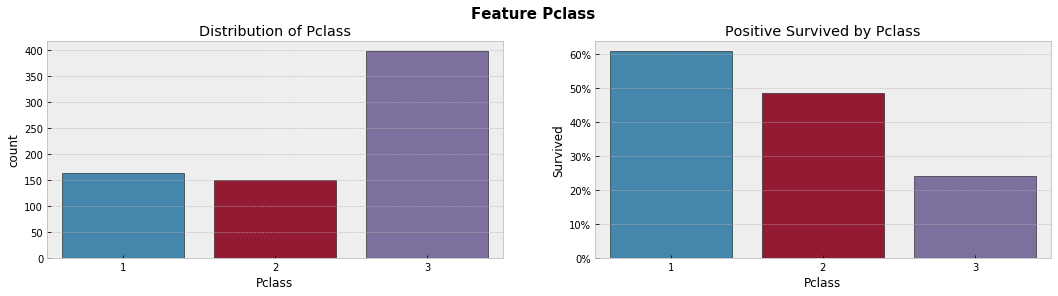

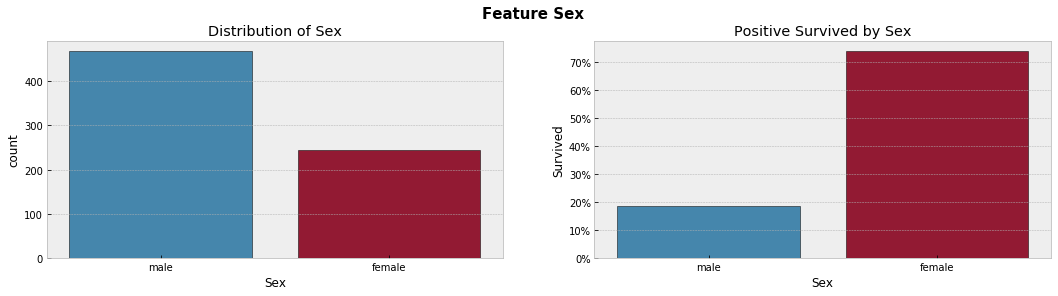

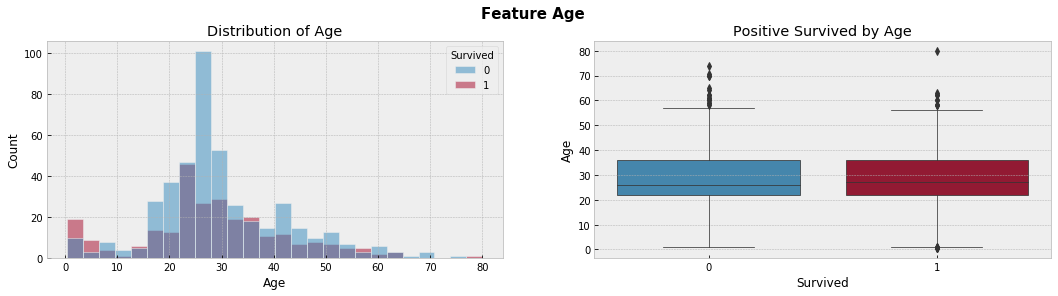

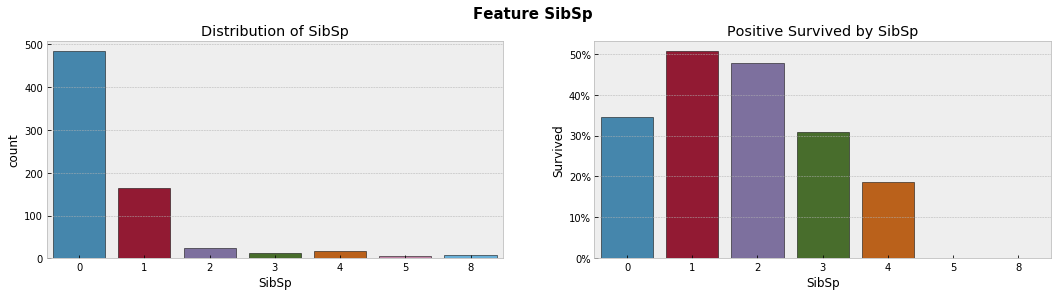

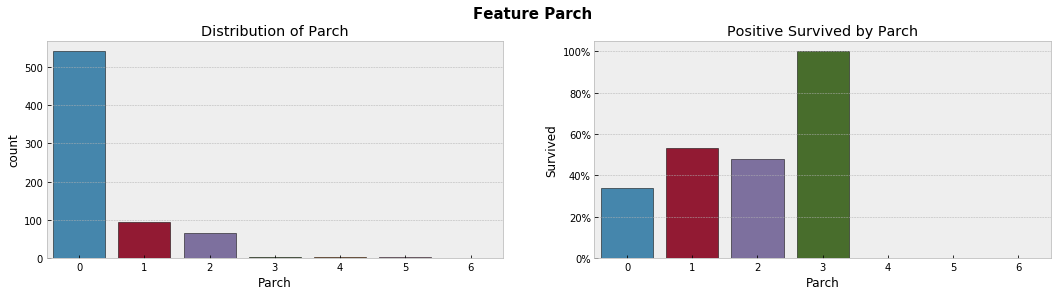

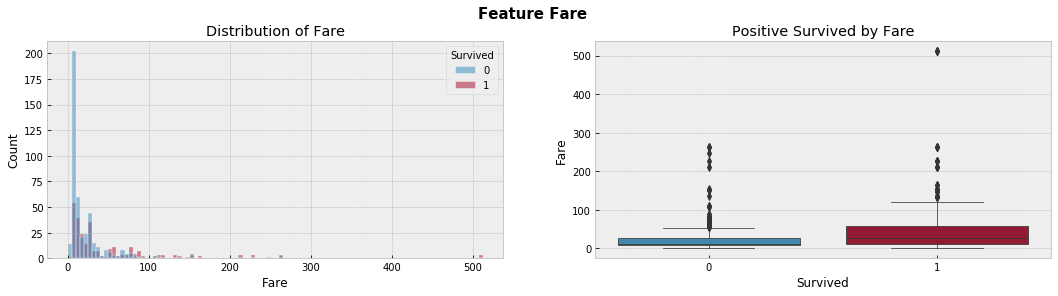

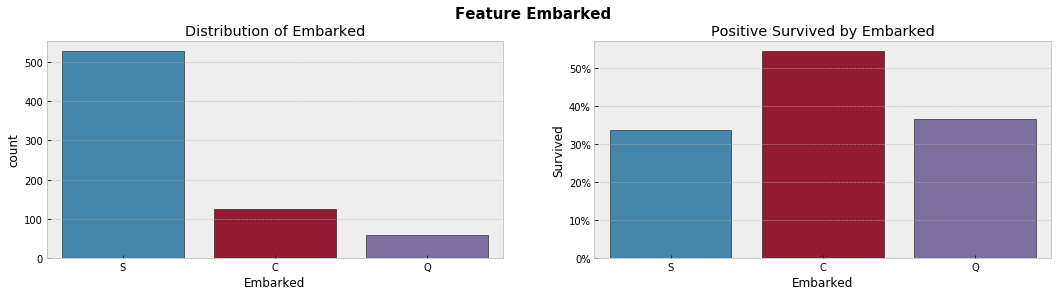

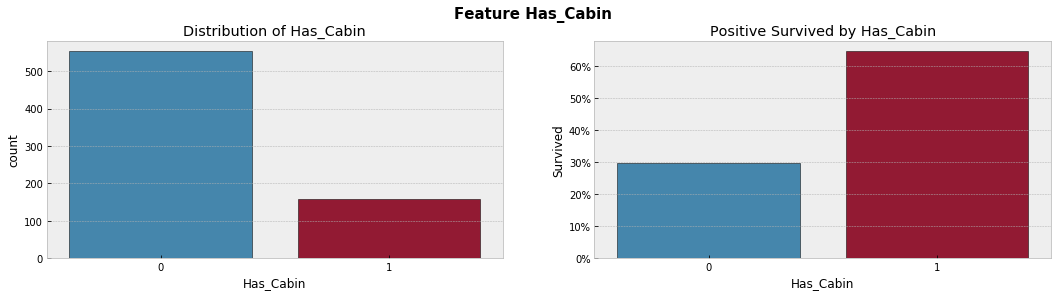

In [31]:
# Function to create plots (histograms, barplots & boxplots) to visualize features' relationship to target variable
def EDA(df, disc_feats, cont_feats, target):
    for col in df.columns:
        if col in disc_feats:
            fig, ax = plt.subplots(1, 2, figsize=(18, 4))
            fig.suptitle(f'Feature {col}', fontsize=15, fontweight='bold', y=1)
            
            sns.countplot(x=col, 
                          data=df, 
                          ax=ax[0],
                         ec='black')
            ax[0].set_title(f'Distribution of {col}')
            #ax[0].set_xticklabels(df[col], rotation=45, fontsize=8)
            
            sns.barplot(x=col, 
                        y=target, 
                        data=df, 
                        ax=ax[1], 
                        ec='black', 
                        ci=None)
            ax[1].set_title(f'Positive {target} by {col}')
            ax[1].set_yticklabels(['{:,.0%}'.format(x) for x in ax[1].get_yticks()])
            #ax[1].set_xticklabels(df[col], rotation=45, fontsize=8)
            plt.show()

        elif col in cont_feats:
            fig, ax = plt.subplots(1, 2, figsize=(18, 4))
            fig.suptitle(f'Feature {col}', fontsize=15, fontweight='bold', y=1)
            
            sns.histplot(x=col, 
                         hue=target, 
                         data=df, 
                         ax=ax[0])
            ax[0].set_title(f'Distribution of {col}')
            
            sns.boxplot(x=target, 
                        y=col, 
                        data=df, 
                        ax=ax[1], 
                        linewidth=0.75)
            ax[1].set_title(f'Positive {target} by {col}')
            plt.show()
            
EDA(train_data01, disc_feats, cont_feats, target)

The plots above show some interesting trends that are useful for formulating hypothesis for our analysis:
* 'Pclass' shows a disproportionate % of survivors in 1st and 2nd class, whereas the vast majority of passengers were located in 3rd class
* 'Sex' shows that over 70% of women aboard survived, compared to less than 20% of men
* Some segments of 'SibSp' and 'Parch' were more likely to have survived than lone passengers
* 'Fare' indicates that passengers who paid higher fares were more likely to have survived
* Passengers departing from port C (Cherbourg) were more likely to have survived than others
* Passengers with a cabin represented a minority but were far more likely to survive (>60%) than those without (30%)

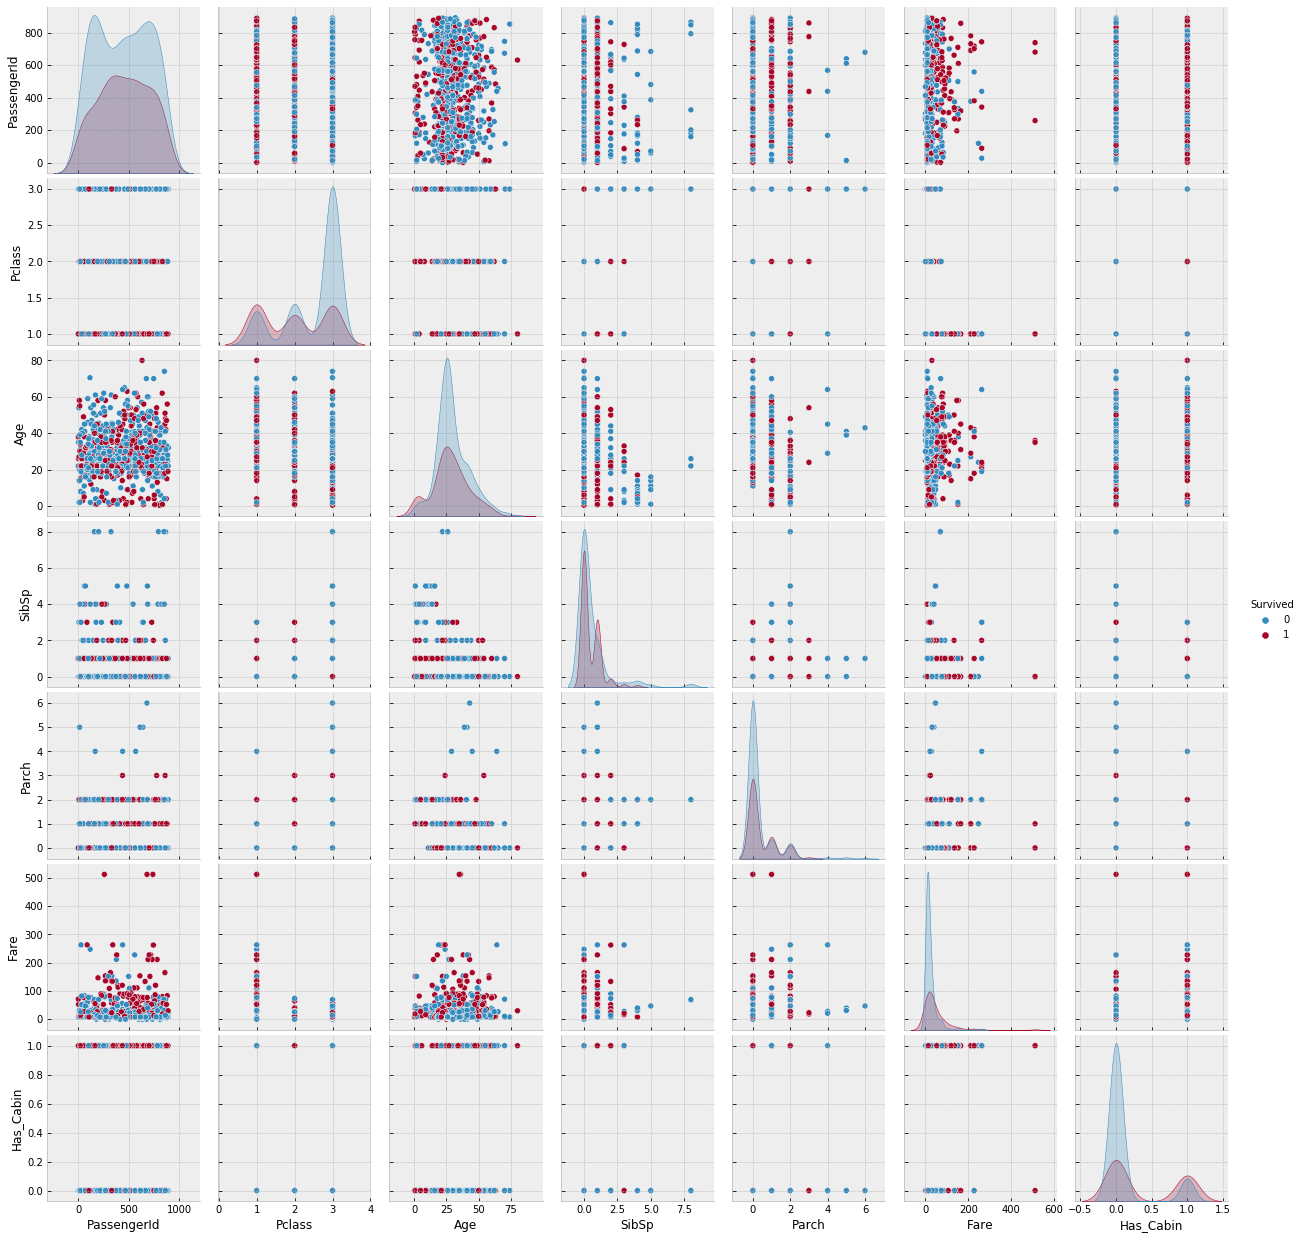

In [32]:
# Pairplots with numeric features' relation to each other & to target variable
sns.pairplot(data=train_data01, hue=target, diag_kind='kde')
plt.show()

Although a bit busy, the plots above seem to confirm some of the findings from the previous step, with a disproportionate of victims among 3rd class passengers, traveling without family (especially 'Parch'), and without a cabin onboard.

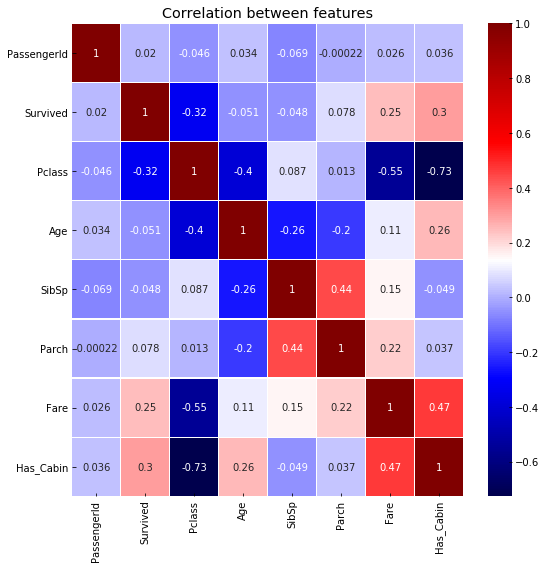

In [33]:
# Correlation matrix with numeric features' relation to each other & to target variable
# Available cmap options for Correlation Matrix: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, crest, crest_r, cubehelix, cubehelix_r, flag, flag_r, flare, flare_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r
ax = sns.heatmap(train_data01.corr(), annot=True, cmap='seismic', linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(8, 8)
plt.title('Correlation between features')
plt.tight_layout()

# Format adjustment to avoid cutting off first & last line
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

The correlation heatmap shows highest positive correlation between our target variable and features 'Has_Cabin' and 'Fare', and highest negative correlation with feature 'Pclass'. As expected, these variables also have high negative correlation between them.

This heatmap is also useful for spotting variables that have high correlation with each other, suggesting that the analysis may be simplified by dropping or merging some of these features without considerable impact to the results - for example, 'SibSP' and 'Parch' show a high positive correlation with each other.

### 3.2. Correlation Analysis

In [34]:
# Split numeric & categorical features ('PassengerId', 'Name', 'Ticket' are ignored for now)
num_feats = ['Age', 
             'SibSp', 
             'Parch', 
             'Fare']
cat_feats = ['Pclass', 
             'Sex', 
             'Embarked', 
             'Has_Cabin']

In [35]:
# Measure correlation between target and numeric features using pandas
train_data01[num_feats+[target]].corr()[target].round(4).sort_values()

Age        -0.0506
SibSp      -0.0476
Parch       0.0783
Fare        0.2466
Survived    1.0000
Name: Survived, dtype: float64

In [36]:
# Measure correlation between target and categorical features using a function to calculate Cramer's V
def cramer_v(df, cat_cols):
    df=df
    cat_cols=cat_cols
    dict_cramer = {}
    for cat in cat_cols: 
        cramer_v_list = []
        for cat_ in cat_cols:
            df_cross = pd.crosstab(df[cat], df[cat_])
            chi2_test, p, df_, arr = stats.chi2_contingency(df_cross)
            r = len(df_cross)
            c = len(df_cross.columns)
            n = df_cross.to_numpy().sum()
            V = np.sqrt((chi2_test/(n*(np.min([r,c]) -1))))
            cramer_v_list.append(V)
        dict_cramer[cat] = cramer_v_list
        df_v_cramer = pd.DataFrame(dict_cramer)
        df_v_cramer.index=cat_cols
    return df_v_cramer

cramer_v(train_data01, cat_feats+[target])[target].round(4).sort_values()

Embarked     0.1605
Has_Cabin    0.2969
Pclass       0.3254
Sex          0.5387
Survived     0.9970
Name: Survived, dtype: float64

The correlation analysis coincides with the graphical analysis, pointing to high relevance of features 'Sex' (0.54), 'Pclass' (0.33), 'Has_Cabin' (0.30) and 'Fare' (0.25). 

# 4. Feature Engineering

### 4.1. Irrelevant Features

In [37]:
# Drop irrelevant features: 'PassengerId', 'Ticket'
irrelevant_feats = ['PassengerId', 'Ticket']
train_data01.drop(irrelevant_feats, axis=1, inplace=True)

### 4.2. 'SibSp' & 'Parch'

In [38]:
# Create a new feature that uses 'SibSp' & 'Parch' to determine if a passenger was traveling by themselves
# Drop 'SibSp' & 'Parch'
train_data01['Travel_Alone'] = np.where((train_data01['SibSp'] + train_data01['Parch']) > 0, 0, 1)
train_data01.drop(['SibSp', 'Parch'], axis=1, inplace=True)

### 4.3. 'Age'

In [39]:
# Create a new feature that groups into 4 bins values in 'Age'
# Drop 'Age'
train_data01['Age_Band'] = pd.cut(train_data01['Age'],
                                  pd.IntervalIndex.from_tuples([(0,25), (25,50), (50,75), (75,100)]))
train_data01.drop('Age', axis=1, inplace=True)

### 4.4. 'Name'

In [40]:
# Create a new feature that extracts title prefixes in 'Name' & count total of each
train_data01['Title'] = train_data01['Name'].str.extract(' ([A-Za-z]+)\.')
train_data01['Title'].value_counts()

Mr          419
Miss        143
Mrs          96
Master       33
Dr            5
Rev           5
Col           2
Mlle          2
Major         2
Ms            1
Lady          1
Countess      1
Mme           1
Capt          1
Name: Title, dtype: int64

In [41]:
# Replace similar titles with their most common synonym, and group all others into a new category
train_data01['Title'] = train_data01['Title'].replace(['Col', 'Major'], 'Mr')
train_data01['Title'] = train_data01['Title'].replace(['Ms', 'Mlle'], 'Miss')
train_data01['Title'] = train_data01['Title'].replace(['Countess', 'Lady', 'Mme'], 'Mrs')

common_titles = ['Mr', 'Miss', 'Mrs']
train_data01['Title'] = train_data01['Title'].apply(lambda x: x if x in common_titles else 'Other')

# View total passengers in each category for 'Title'
# Drop 'Name'
print(train_data01['Title'].value_counts())
train_data01.drop('Name', axis=1, inplace=True)

# Review train DF (post-adjustments)
train_data01.head(3)

Mr       423
Miss     146
Mrs       99
Other     44
Name: Title, dtype: int64


,Survived,Pclass,Sex,Fare,Embarked,Has_Cabin,Travel_Alone,Age_Band,Title
331,0,1,male,28.500,S,1,1,"(25, 50]",Mr
733,0,2,male,13.000,S,0,1,"(0, 25]",Mr
382,0,3,male,7.925,S,0,1,"(25, 50]",Mr


### 4.5. Remaining Features

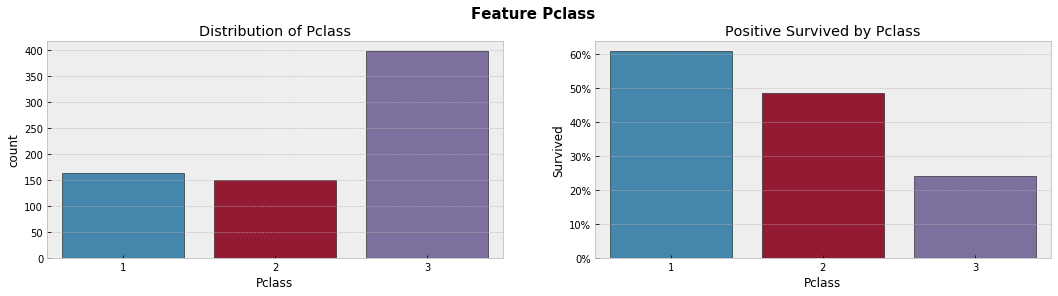

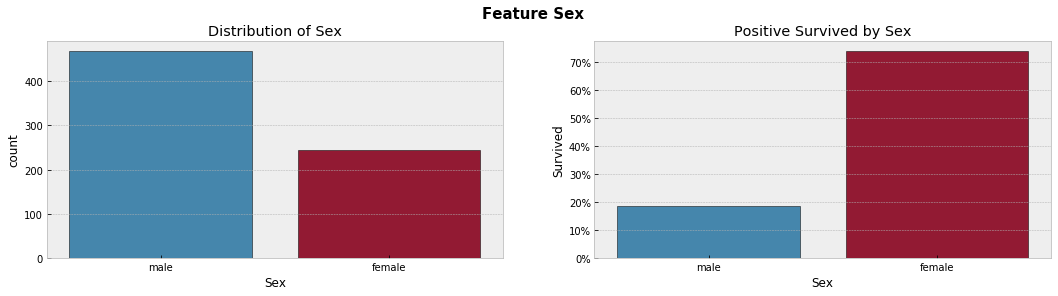

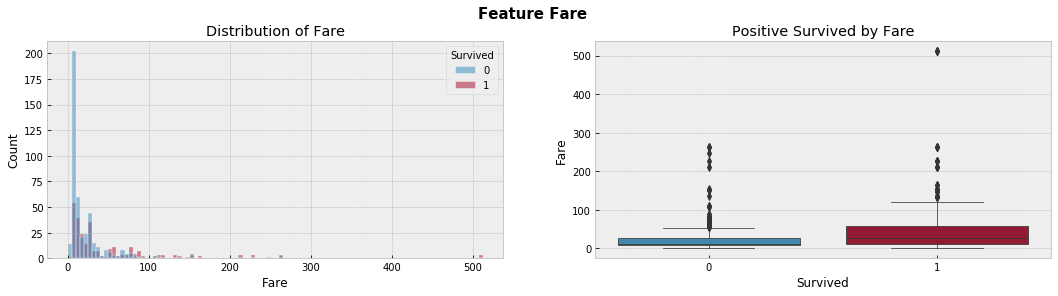

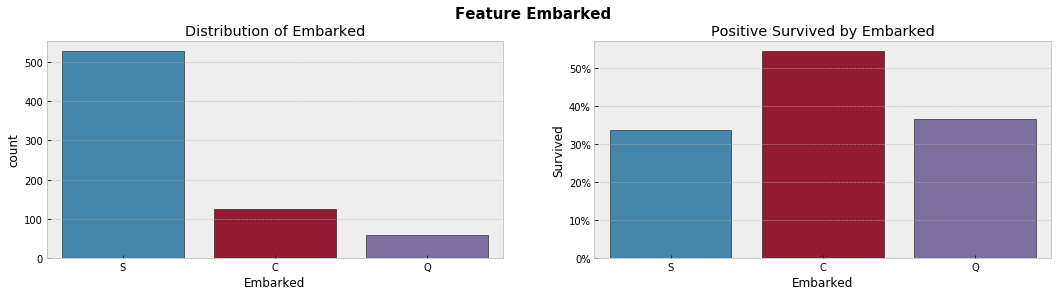

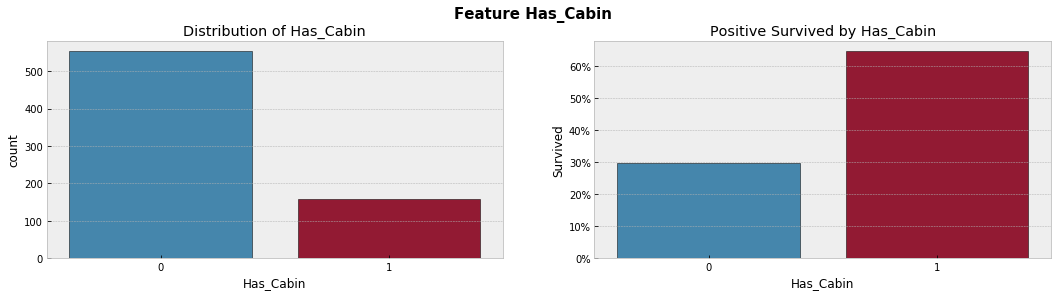

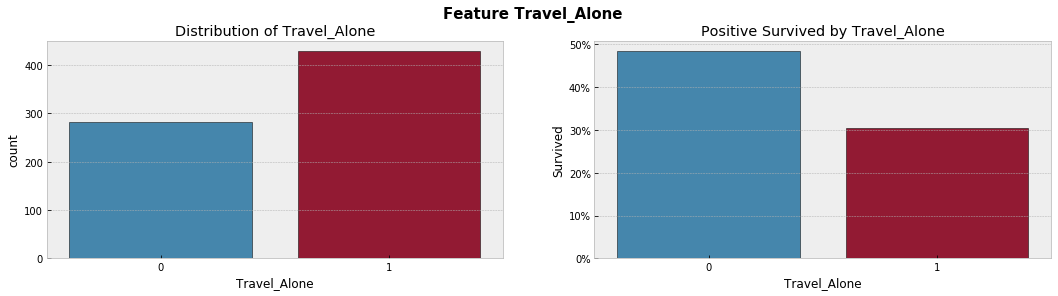

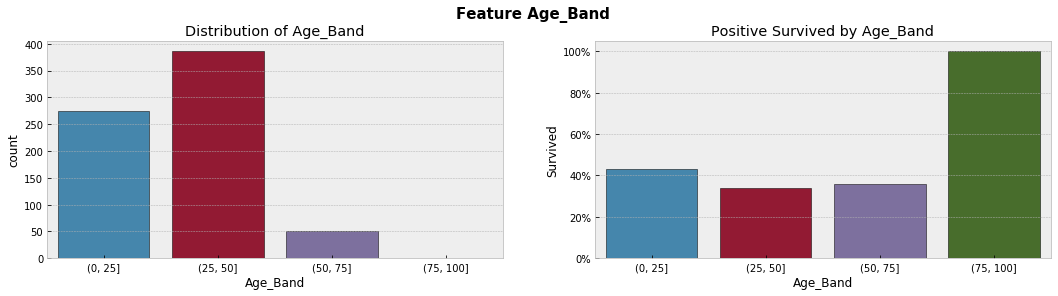

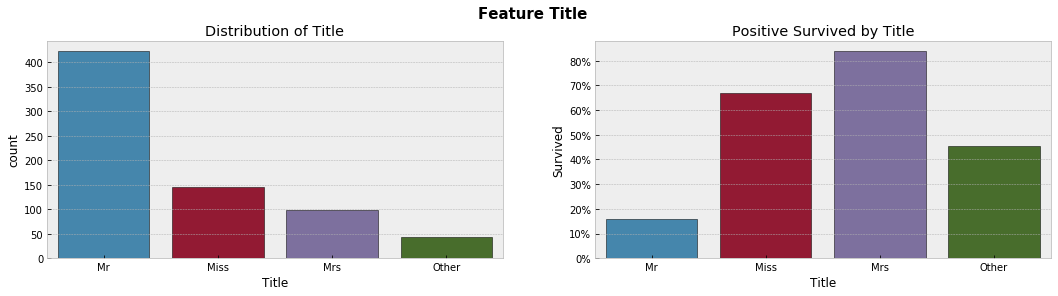

In [42]:
# Review plots of remaining features' relationship to target variable
disc_feats = ['Pclass', 
              'Sex', 
              'Embarked', 
              'Has_Cabin', 
              'Travel_Alone', 
              'Age_Band', 
              'Title']
cont_feats = ['Fare']
EDA(train_data01, disc_feats, cont_feats, target)

The remaining features in the dataset all seem to show a disproportionate amount of survival/non-survival rates, which indicates they are most likely relevant to continue our analysis.

# 5. Feature Selection

Two methods will be used to find the best set of features to build a useful model:
* <u>Filter Method</u>: picks up the intrinsic properties of the features measured via univariate statistics; faster and less computationally expensive than wrapper methods
* <u>Wrapper Method</u>: requires some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier (in this case a Random Forest) with that feature subset; usually results in better predictive accuracy than filter methods

In [43]:
# Split train DF into X_train & y_train
X_train = train_data01.drop(target, axis=1)
y_train = train_data01[target]

### 5.1. Filter Method

In [44]:
# Data types
X_train.dtypes

Pclass             int64
Sex               object
Fare             float64
Embarked          object
Has_Cabin          int64
Travel_Alone       int64
Age_Band        category
Title             object
dtype: object

In [45]:
# Split X_train into numeric and categorical features
X_train_num = X_train.loc[:,['Fare']] # use ANOVA
X_train_cat = X_train.loc[:,['Pclass', 
                             'Sex', 
                             'Embarked', 
                             'Has_Cabin', 
                             'Travel_Alone', 
                             'Age_Band', 
                             'Title']] # use chi2

#### 5.1.1. Numeric Features

In [46]:
# Update list of numeric features based on remaining features
num_feats = X_train_num.columns.tolist()
num_feats

['Fare']

In [47]:
# Perform hypothesis test on numeric features using ANOVA
anova_result = f_classif(X_train_num, y_train)

# Arrange p-values into a series
p_values_num_feats = pd.Series(anova_result[1])
p_values_num_feats.index = num_feats

# View ANOVA results
p_values_num_feats

Fare    2.506434e-11
dtype: float64

In [48]:
# Filter only features with a p-value < 0.05
filter_num_feats = p_values_num_feats[p_values_num_feats < 0.05].index.tolist()
filter_num_feats

['Fare']

#### 5.1.2. Categorical Features

In [49]:
# Update list of categorical features based on remaining features
cat_feats = X_train_cat.columns.tolist()
cat_feats

['Pclass', 'Sex', 'Embarked', 'Has_Cabin', 'Travel_Alone', 'Age_Band', 'Title']

In [50]:
# Perform hypothesis test on categorical features using chi2
p_values_cat_feats = {}

for col in cat_feats:
    df_cross = pd.crosstab(X_train_cat[col], train_data01[target])
    p_value = stats.chi2_contingency(df_cross)[1]
    p_values_cat_feats[col] = p_value
    
# Arrange dictionary with columns & p-values into a series
p_values_cat_feats = pd.Series(p_values_cat_feats)

# View chi2 results
p_values_cat_feats

Pclass          4.224782e-17
Sex             7.503669e-47
Embarked        1.043689e-04
Has_Cabin       2.336744e-15
Travel_Alone    2.153735e-06
Age_Band        6.518637e-02
Title           8.916816e-50
dtype: float64

In [51]:
# Filter only features with a p-value < 0.05
filter_cat_feats = p_values_cat_feats[p_values_cat_feats < 0.05].index.tolist()
filter_cat_feats

['Pclass', 'Sex', 'Embarked', 'Has_Cabin', 'Travel_Alone', 'Title']

#### 5.1.3. Summary - Filter Method

In [52]:
# Unify features (Numeric + categorical) selected using Filter Method
features_filter = filter_num_feats + filter_cat_feats
features_filter

['Fare', 'Pclass', 'Sex', 'Embarked', 'Has_Cabin', 'Travel_Alone', 'Title']

Only one feature ('Age_Band') was discarded after performing the Filter Method with ANOVA and chi2.

### 5.2. Wrapper Method

In [53]:
# Transform categorical features in X_train into type 'object' for use in Boruta model
for col in cat_feats:
    X_train[col] = X_train[col].astype('object')

In [54]:
# Define Frequency Encoder for categorical features 
freq_enc = CountFrequencyEncoder(encoding_method='frequency', variables=cat_feats)

# Fit data to encoder
X_train_encoded = freq_enc.fit_transform(X_train)

# View encoded DF
X_train_encoded.head(3)

,Pclass,Sex,Fare,Embarked,Has_Cabin,Travel_Alone,Age_Band,Title
331,0.228933,0.655899,28.500,0.740169,0.223315,0.602528,0.542135,0.594101
733,0.212079,0.655899,13.000,0.740169,0.776685,0.602528,0.386236,0.594101
382,0.558989,0.655899,7.925,0.740169,0.776685,0.602528,0.542135,0.594101


In [55]:
# Define Random Forest model for use in Boruta
rforest = RandomForestClassifier(n_jobs=-1, max_depth=5)

# Define Boruta feature selection library
boruta_selector = BorutaPy(rforest, 
                           n_estimators=50, 
                           max_iter=100, 
                           random_state=42)

# Fit data to model
boruta_selector.fit(np.array(X_train_encoded), y_train)

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=50,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x7FD53F4F4E20),
         n_estimators=50, random_state=RandomState(MT19937) at 0x7FD53F4F4E20)

In [56]:
# Filter only features deemed significant by Boruta
features_boruta = X_train_encoded.loc[:, boruta_selector.support_].columns.tolist()
features_boruta

['Pclass', 'Sex', 'Fare', 'Title']

Four features ('Embarked', 'Has_Cabin', 'Travel_Alone', 'Age_Band') were discarded after performing the Wrapper Method using Boruta.

### 5.3. Summary -  Feature Selection

Four features were selected by intersecting the results of the Filter & Wrapper methods for feature selection:

In [57]:
# View features selected by both Filter & Wrapper Method
selected_features = list(set(features_boruta).intersection(set(features_filter)))
selected_features

['Pclass', 'Fare', 'Sex', 'Title']

In [58]:
# Filter X_train for the selected features
X_train = X_train[selected_features]
X_train.head(3)

,Pclass,Fare,Sex,Title
331,1,28.500,male,Mr
733,2,13.000,male,Mr
382,3,7.925,male,Mr


In [59]:
# Update list of numeric features based on remaining features
cat_feats_updated = ['Sex', 'Pclass', 'Title']
num_feats_updated = ['Fare']

# 6. Data Prep

A scaler is applied to numeric features in order to standardize them and guarantee that each variable contributes equally to the model.

In [60]:
# Define scaling for numeric features (robust scaler is ideal due to outliers in feature)
pipe_num_feats = ('robust_scaler', RobustScaler(),
                  num_feats_updated)

An encoder is appplied to categorical features in order to convert them to numbers so they can be input into the model, since most machine learning models only accept numerical variables.

In [61]:
# Define encoding for categorical features
pipe_cat_feats = ('freq_encoder', CountFrequencyEncoder(encoding_method='frequency', variables=cat_feats_updated),
                  cat_feats_updated)

In [62]:
# Use ColumnTransformer to apply data transformations to different features in train df
transformers = [pipe_cat_feats, pipe_num_feats]
preprocessor = ColumnTransformer(transformers)

# 7. Model Adjustment

A Logistic Regression is chosen as the model to be used for this first ML exercise. The scaled and encoded data is passed to the model via a pipeline for fitting.

In [63]:
# Define Logistic Regression model
model = LogisticRegression(random_state=42)

In [64]:
# Create Pipeline for preprocessing data & defining model
pipe = Pipeline(steps=[('p', preprocessor),
                       ('m', model)])

# Fit data to pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('p',
                 ColumnTransformer(transformers=[('freq_encoder',
                                                  CountFrequencyEncoder(encoding_method='frequency',
                                                                        variables=['Sex',
                                                                                   'Pclass',
                                                                                   'Title']),
                                                  ['Sex', 'Pclass', 'Title']),
                                                 ('robust_scaler',
                                                  RobustScaler(), ['Fare'])])),
                ('m', LogisticRegression(random_state=42))])

# 8. Model Evaluation & Threshold Selection

### 8.1. Test DF Prep

The adjustments made to the train set need to be applied to the test set to guarantee consistency:

In [65]:
# Apply all DF adjustments to test set
df_test['Title'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.')
df_test['Title'] = df_test['Title'].replace(['Col','Major'], 'Mr')
df_test['Title'] = df_test['Title'].replace(['Ms', 'Lady', 'Mlle'], 'Miss')
df_test['Title'] = df_test['Title'].replace(['Countess', 'Lady', 'Mme'], 'Mrs')
#common_titles = ['Mr', 'Miss', 'Mrs']
df_test['Title'] = df_test['Title'].apply(lambda x: x if x in common_titles else 'Other')

unused_features_final = ['PassengerId',
                         'Name',
                         'Age',
                         'SibSp',
                         'Parch',
                         'Ticket',
                         'Cabin',
                         'Embarked']
df_test.drop(unused_features_final, axis=1, inplace=True)

# View test DF
df_test.head(3)

,Survived,Pclass,Sex,Fare,Title
709,1,3,male,15.2458,Other
439,0,2,male,10.5000,Mr
840,0,3,male,7.9250,Mr


In [66]:
# Split test DF into X_test & y_test
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [67]:
# High level summary
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (712, 4)
X_test shape: (179, 4)
y_train shape: (712,)
y_test shape: (179,)


### 8.2. Make Predictions & Evaluate Model

In [68]:
# Calculate model's train & test predictions
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [69]:
# Accuracy: % of passengers correctly classified by the model 
# (True Pos + True Neg) / (True Pos + False Pos + False Neg + True Neg)
print('Accuracy in train set:', pipe.score(X_train, y_train).round(5))
print('Accuracy in test set:', accuracy_score(y_test, y_pred_test).round(5))

Accuracy in train set: 0.79073
Accuracy in test set: 0.77654


In [70]:
# Precision: % of passengers classified by the model as survivors that is correct
# True Pos / (True Pos + False Pos)
print('Precision in train set:', precision_score(y_train, y_pred_train).round(5))
print('Precision in test set:', precision_score(y_test, y_pred_test).round(5))

Precision in train set: 0.71956
Precision in test set: 0.72368


In [71]:
# Recall: % of survivors that were correctly classified by the model 
# True Pos / (True Pos + False Neg)
print('Recall in train set:', recall_score(y_train, y_pred_train).round(5))
print('Reest in test set:', recall_score(y_test, y_pred_test).round(5))

Recall in train set: 0.72761
Reest in test set: 0.74324


In [72]:
# F1 Score: weighted average of Precision and Recall 
# 2 * (Recall * Precision) / (Recall + Precision)
print('F1 score for train set:', f1_score(y_train, y_pred_train).round(5))
print('F1 score for test set:', f1_score(y_test, y_pred_test).round(5))

F1 score for train set: 0.72356
F1 score for test set: 0.73333


In [73]:
# Confusion matrix (train): 
# True Positive  | False Negative
# False Positive | True Negative
confusion_matrix(y_train, y_pred_train)

array([[368,  76],
       [ 73, 195]])

In [74]:
# Confusion matrix (test)
# True Positive  | False Negative
# False Positive | True Negative
confusion_matrix(y_test, y_pred_test)

array([[84, 21],
       [19, 55]])

The similar results achieved by the model in both train & test predictions indicate that there is no overfitting, which means that the model can be expected to generalize or fit well on unseen dataset; hence, it can be assumed that the model works as intended!

### 8.3. Threshold adjustment

In [75]:
# calculate probability of survival for each passenger in a variable
y_pred_proba = pipe.predict_proba(X_test)[:, 1]

# calculate AUC
auc = roc_auc_score(y_test, y_pred_proba)
print('AUC: %.5f' % auc)

AUC: 0.86248


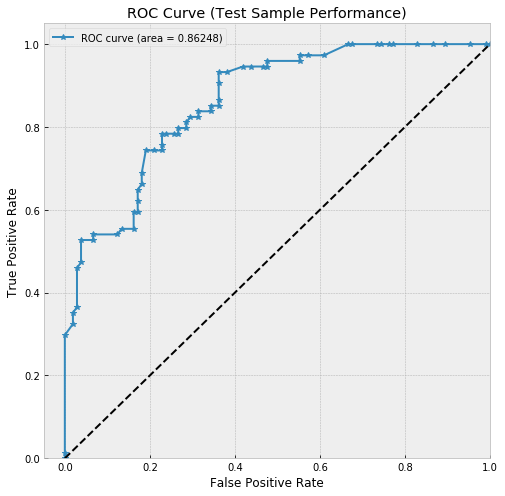

In [76]:
# calculate roc curve (determine the false positive and true positive rates)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8,8))
plt.plot(fpr, 
         tpr, 
         '*-', 
         label='ROC curve (area = %0.5f)' % auc)
plt.plot([0,1],
         [0,1],
         'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Test Sample Performance)')
plt.legend(loc='best')
plt.show()

In [77]:
# Threshold adjustment: Create function to determine accuracy for each possible threshold level
scores = {}

for threshold in np.arange(0, 1, 0.01):
    y_bina = np.where(y_pred_proba>threshold, 1, 0)
    accur = accuracy_score(y_test, y_bina)
    scores[threshold] = accur

In [78]:
# Threshold adjustment: Identify threshold with highest accuracy
max_threshold = max(scores, key=scores.get)
max_threshold

0.63

After determining that a threshold of 0.63 delivers the best result for separating surviving & non-surviving passengers in this Logistic Regression model -meaning that a passenger must achieve a 63% chance of surviving in this model in order to be classified as a survivor-, the test set is evaluated with this parameter and shows an imprvement in accuracy compared to the original score of 0.77654:

In [79]:
# Accuracy in test using best threshold
scores[max_threshold].round(5)

0.78212

# 9. Kaggle Submission

In [80]:
# Create submission DF and store PassengerID
submission = df_testanic[['PassengerId']]
submission.head(3)

,PassengerId
0,892
1,893
2,894


In [81]:
# Apply all DF adjustments to test set
df_testanic['Title'] = df_testanic['Name'].str.extract(' ([A-Za-z]+)\.')
df_testanic['Title'] = df_testanic['Title'].replace(['Col','Major'], 'Mr')
df_testanic['Title'] = df_testanic['Title'].replace(['Ms', 'Lady', 'Mlle'], 'Miss')
df_testanic['Title'] = df_testanic['Title'].replace(['Countess', 'Lady', 'Mme'], 'Mrs')
#common_titles = ['Mr', 'Miss', 'Mrs']
df_testanic['Title'] = df_testanic['Title'].apply(lambda x: x if x in common_titles else 'Other')

unused_features_final = ['PassengerId',
                         'Name',
                         'Age',
                         'SibSp',
                         'Parch',
                         'Ticket',
                         'Cabin',
                         'Embarked']
df_testanic.drop(unused_features_final, axis=1, inplace=True)

# View test DF
df_testanic.head(3)

,Pclass,Sex,Fare,Title
0,3,male,7.8292,Mr
1,3,female,7.0000,Mrs
2,2,male,9.6875,Mr


In [82]:
# Missing values in test DF
df_testanic.isnull().sum()

Pclass    0
Sex       0
Fare      1
Title     0
dtype: int64

In [83]:
# New adjustment to account for missing value in test DF - must use Train data
fare_median = df_traintanic['Fare'].median(skipna=True)
df_testanic['Fare'] = df_testanic['Fare'].fillna(fare_median)
df_testanic.isnull().sum()

Pclass    0
Sex       0
Fare      0
Title     0
dtype: int64

In [84]:
# Store probability of survival for each passenger in a variable
y_proba_surv_submission = pipe.predict_proba(df_testanic)[:, 1]

# Create binary classes based on probability and threshold
y_bina_submission = np.where(y_proba_surv_submission>max_threshold, 1, 0)

# Add Survived column to submission DF
submission['Survived'] = y_bina_submission

# View submission DF
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0


In [85]:
# Confirm size of submission DF
submission.shape

(418, 2)

In [86]:
# Export submission DF to csv
#submission.to_csv('Submission_jmod_01.csv', index=False)

The score obtained in the submission set is in line with those achieved in the model evaluation, which leaves me quite satisfied with the work done on my first submission to an ML competition : )